# Frequency Spectrum (FFT)

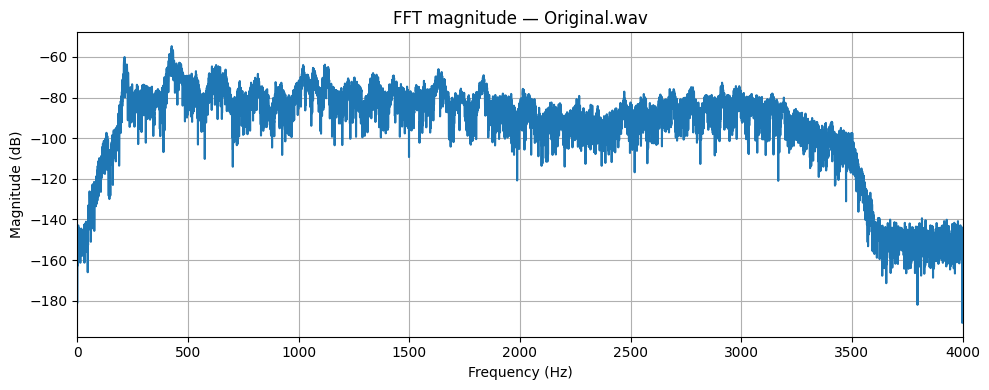

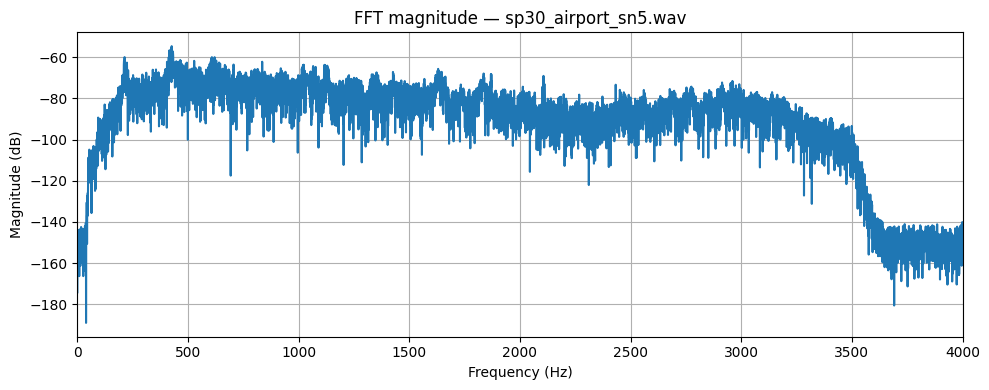

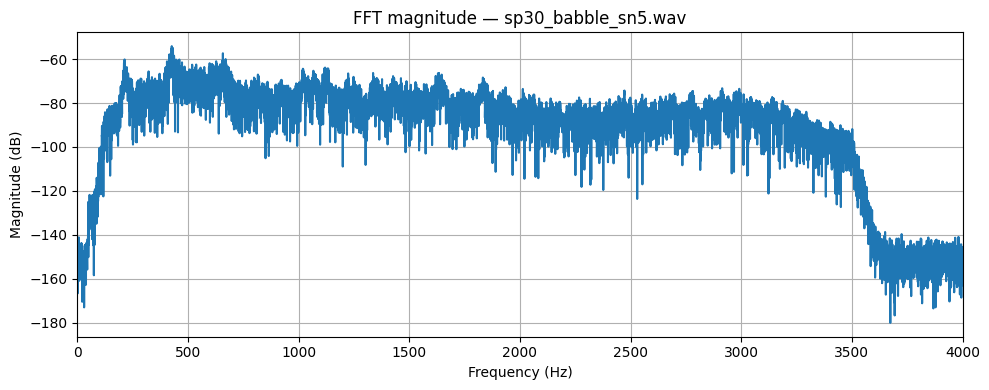

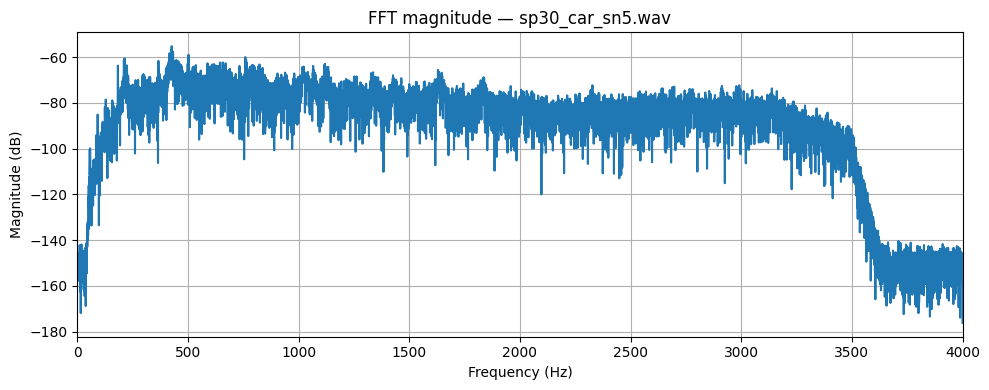

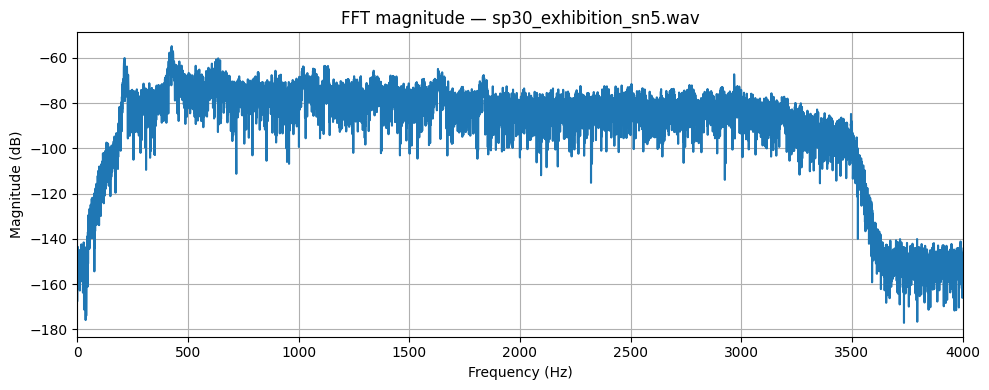

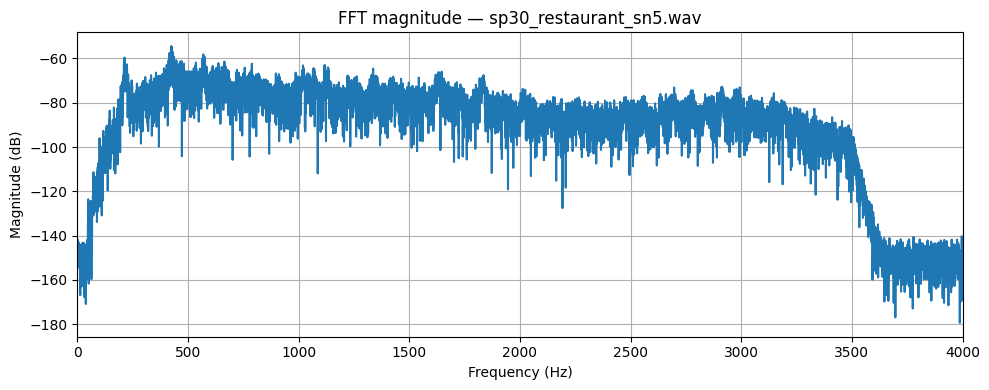

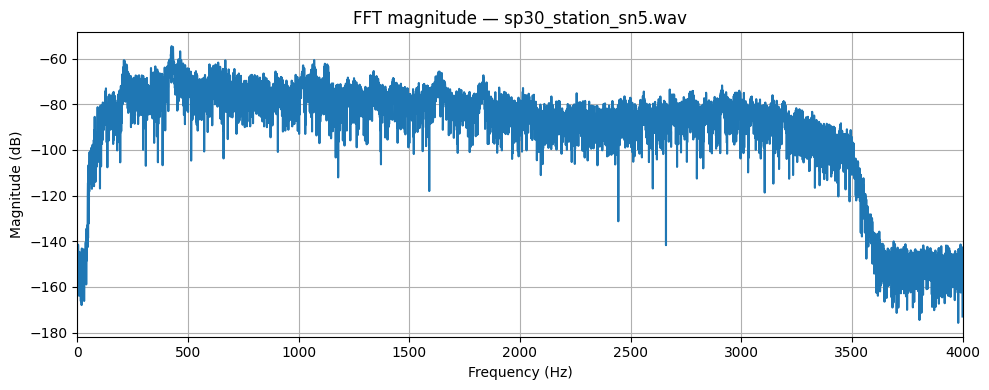

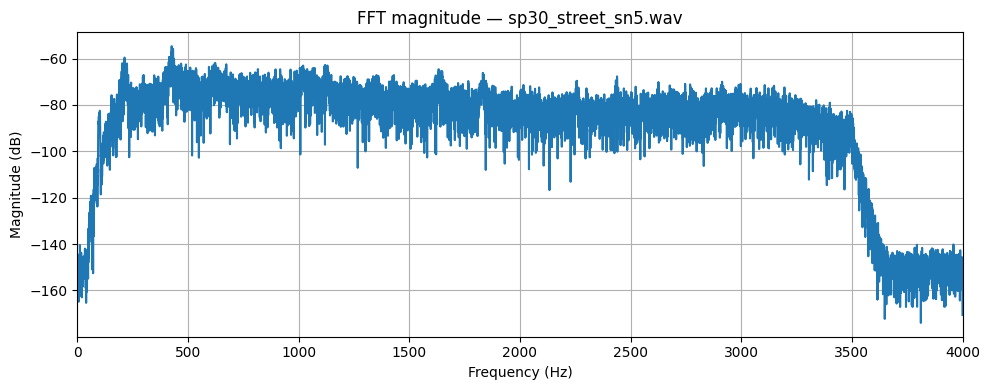

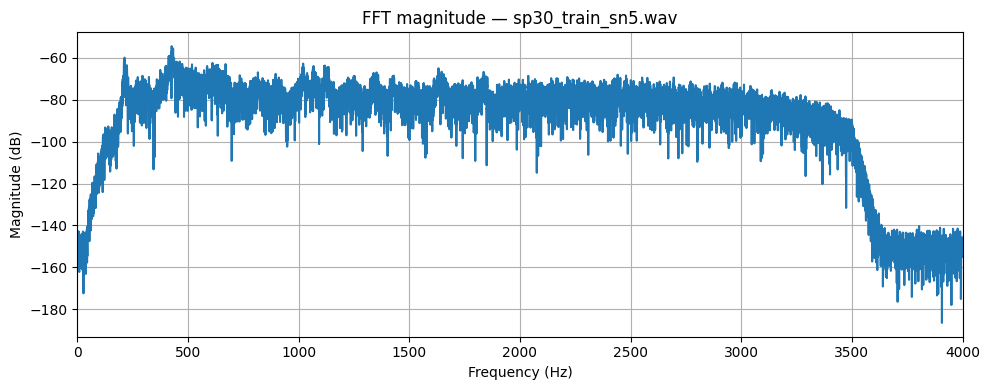

In [1]:
import os
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt

data_folder = "audio/op_end_4_5_6"

def to_mono(x):
    if x.ndim == 1:
        return x
    return x.mean(axis=1)

files = sorted([f for f in os.listdir(data_folder) if f.lower().endswith(".wav")])
if not files:
    raise SystemExit("No .wav files found in folder: " + data_folder)

for fname in files:
    path = os.path.join(data_folder, fname)
    sig, sr = sf.read(path)
    sig = to_mono(sig)
    n = len(sig)
    # compute real FFT
    fft_vals = np.fft.rfft(sig * np.hanning(n))
    fft_mag = np.abs(fft_vals) / n
    freqs = np.fft.rfftfreq(n, 1.0/sr)

    plt.figure(figsize=(10, 4))
    plt.title(f"FFT magnitude — {fname}")
    plt.plot(freqs, 20 * np.log10(fft_mag + 1e-12))  # dB scale
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude (dB)")
    plt.xlim(0, min(sr/2, 16000))  # zoom to 16 kHz if sampling allows
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# IIR Filtering

No clean file found for Original.wav. Correlation will be with original (noisy) signal.


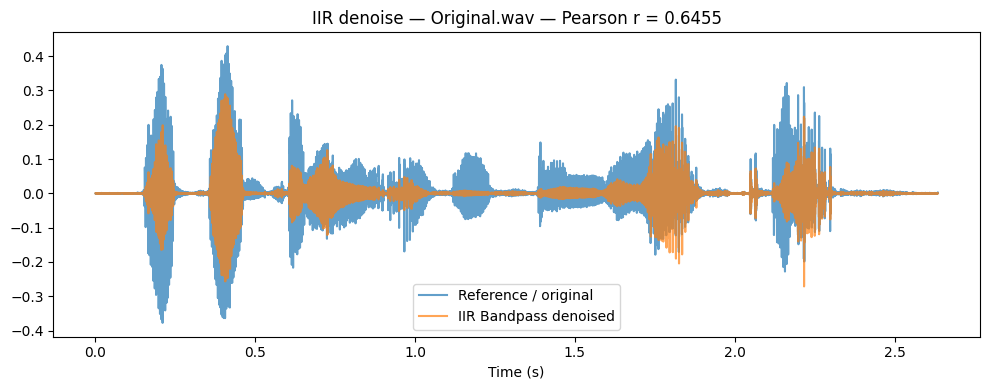

Saved: output_audio/OEP456/iir_out/Original_iir_denoised.wav
No clean file found for sp30_airport_sn5.wav. Correlation will be with original (noisy) signal.


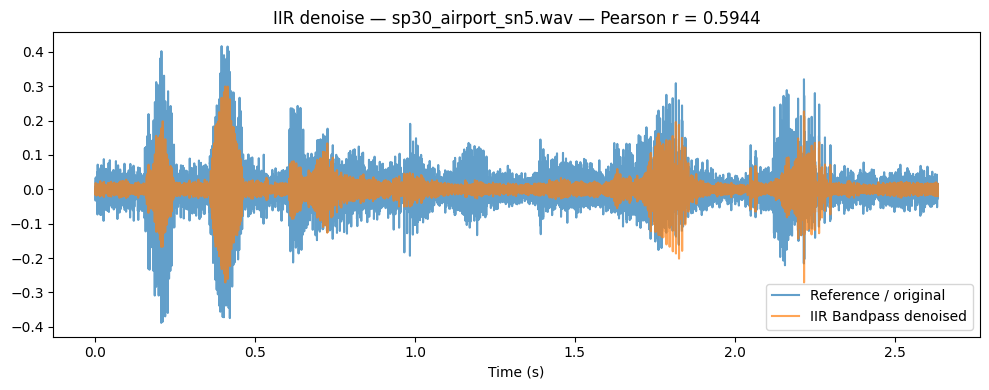

Saved: output_audio/OEP456/iir_out/sp30_airport_sn5_iir_denoised.wav
No clean file found for sp30_babble_sn5.wav. Correlation will be with original (noisy) signal.


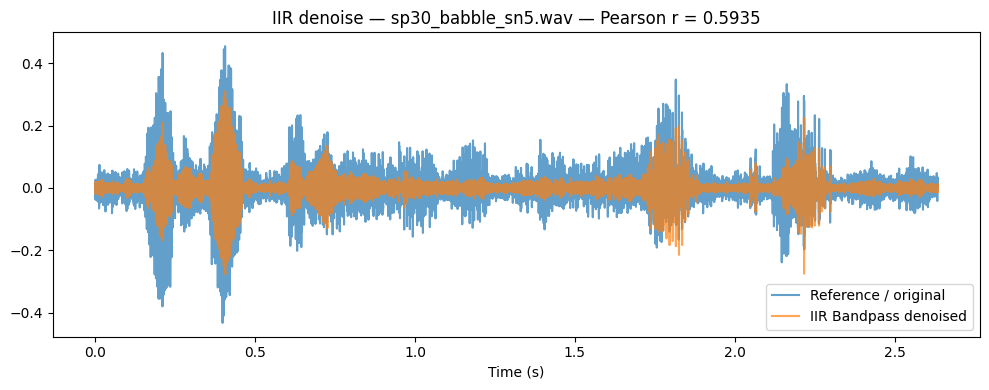

Saved: output_audio/OEP456/iir_out/sp30_babble_sn5_iir_denoised.wav
No clean file found for sp30_car_sn5.wav. Correlation will be with original (noisy) signal.


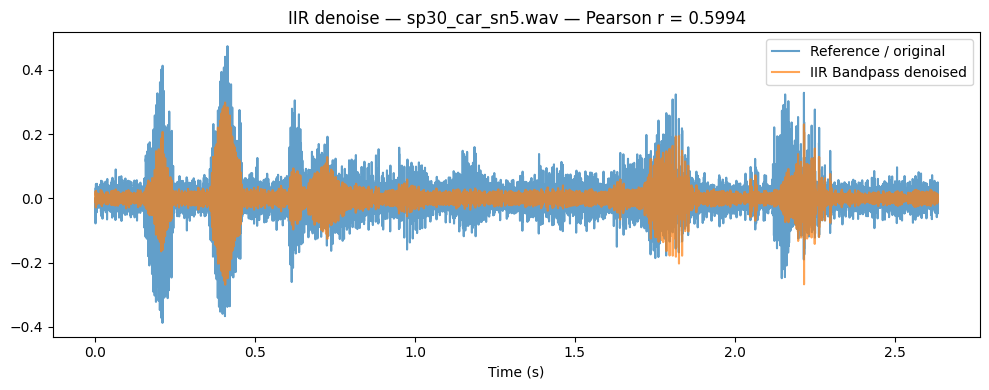

Saved: output_audio/OEP456/iir_out/sp30_car_sn5_iir_denoised.wav
No clean file found for sp30_exhibition_sn5.wav. Correlation will be with original (noisy) signal.


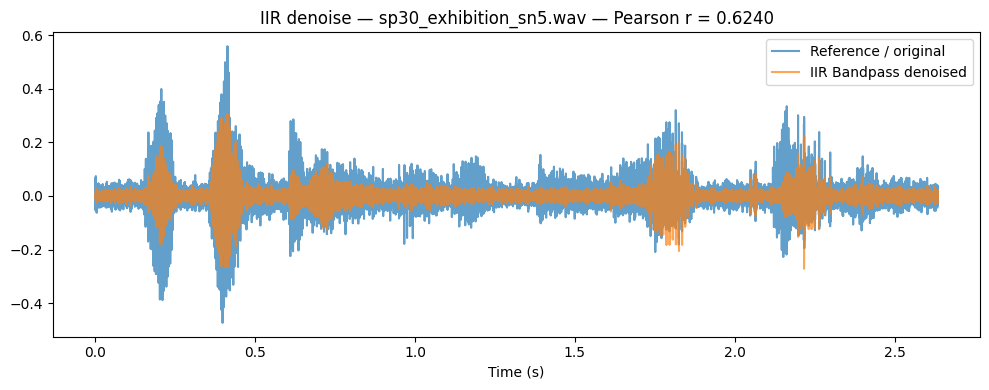

Saved: output_audio/OEP456/iir_out/sp30_exhibition_sn5_iir_denoised.wav
No clean file found for sp30_restaurant_sn5.wav. Correlation will be with original (noisy) signal.


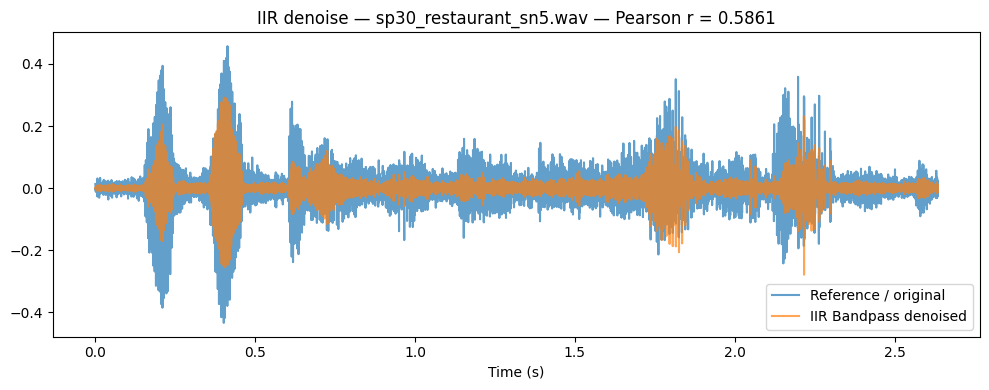

Saved: output_audio/OEP456/iir_out/sp30_restaurant_sn5_iir_denoised.wav
No clean file found for sp30_station_sn5.wav. Correlation will be with original (noisy) signal.


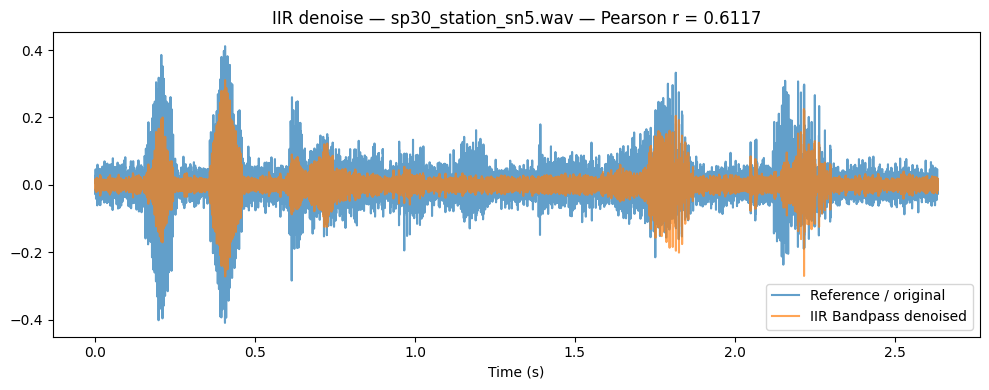

Saved: output_audio/OEP456/iir_out/sp30_station_sn5_iir_denoised.wav
No clean file found for sp30_street_sn5.wav. Correlation will be with original (noisy) signal.


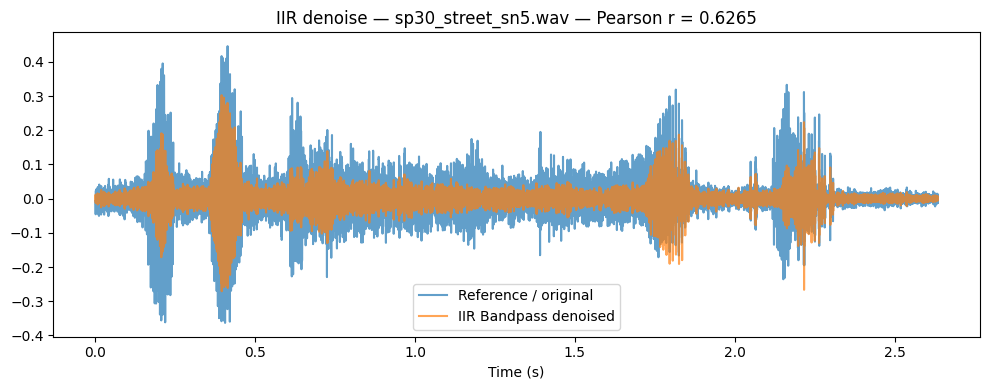

Saved: output_audio/OEP456/iir_out/sp30_street_sn5_iir_denoised.wav
No clean file found for sp30_train_sn5.wav. Correlation will be with original (noisy) signal.


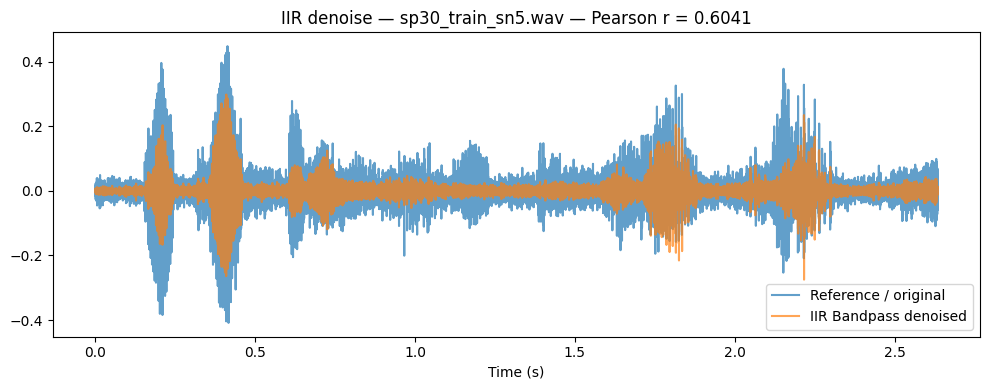

Saved: output_audio/OEP456/iir_out/sp30_train_sn5_iir_denoised.wav


In [19]:
import os
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
from scipy.signal import butter, sosfiltfilt
from scipy.stats import pearsonr

data_folder = "audio/op_end_4_5_6"
lowcut = 1000.0   # Hz
highcut = 2000.0  # Hz
butter_order = 4
eps = 1e-6

def to_mono(x):
    if x.ndim == 1:
        return x
    return x.mean(axis=1)

def butter_bandpass_sos_clamped(low, high, fs, order=4):
    """
    Create a bandpass SOS for frequencies in Hz, safely clamping them inside (0, fs/2).
    Uses scipy.signal.butter(..., fs=fs) so Wn is in Hz.
    """
    ny = 0.5 * fs
    # clamp low/high strictly inside (0, ny)
    if low <= 0:
        print(f"Warning: lowcut ({low}) <= 0. Setting lowcut = {eps}")
        low = eps
    if high >= ny:
        new_high = max(eps, ny - 1.0)  # keep 1 Hz margin if possible
        print(f"Warning: highcut ({high}) >= Nyquist ({ny}). Setting highcut = {new_high}")
        high = new_high
    if low >= high:
        raise ValueError(f"Invalid band after clamping: low={low} >= high={high} (Nyquist={ny})")

    # Using fs parameter allows us to pass Hz directly to butter
    sos = butter(order, [low, high], btype='band', output='sos', fs=fs)
    return sos

def find_clean_candidate(noisy_path):
    d, base = os.path.split(noisy_path)
    name = os.path.splitext(base)[0]
    candidates = [
        os.path.join(d, "clean", base),
        os.path.join(d, name + "_clean.wav"),
        os.path.join(d, "clean_" + base),
        os.path.join(d, "clean", name + ".wav"),
    ]
    for c in candidates:
        if os.path.exists(c):
            return c
    return None

files = sorted([f for f in os.listdir(data_folder) if f.lower().endswith(".wav")])
if not files:
    raise SystemExit("No .wav files found in folder: " + data_folder)

for fname in files:
    noisy_path = os.path.join(data_folder, fname)
    noisy, sr = sf.read(noisy_path)
    noisy = to_mono(noisy)

    try:
        sos = butter_bandpass_sos_clamped(lowcut, highcut, sr, order=butter_order)
    except ValueError as e:
        print(f"Skipping filtering for {fname}: {e}")
        denoised = noisy.copy()
    else:
        # zero-phase filtering with sosfiltfilt for IIR cascades
        denoised = sosfiltfilt(sos, noisy)

    # find clean file
    clean_candidate = find_clean_candidate(noisy_path)
    if clean_candidate:
        clean, sr2 = sf.read(clean_candidate)
        clean = to_mono(clean)
        if sr2 != sr:
            print(f"Warning: sample rate mismatch for {fname} and clean file ({sr} vs {sr2}); resampling not done.")
    else:
        clean = noisy  # fallback
        print(f"No clean file found for {fname}. Correlation will be with original (noisy) signal.")

    L = min(len(denoised), len(clean))
    denoised_trim = denoised[:L]
    clean_trim = clean[:L]
    if denoised_trim.std() == 0 or clean_trim.std() == 0:
        corr = 0.0
    else:
        corr, _ = pearsonr(denoised_trim, clean_trim)

    # Plot
    t = np.arange(L) / sr
    plt.figure(figsize=(10, 4))
    plt.plot(t, clean_trim, label='Reference / original', alpha=0.7)
    plt.plot(t, denoised_trim, label='IIR Bandpass denoised', alpha=0.7)
    plt.title(f"IIR denoise — {fname} — Pearson r = {corr:.4f}")
    plt.xlabel("Time (s)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    
    # --- Save denoised audio to an existing folder ---
    out_dir = "output_audio/OEP456/iir_out"

    # ensure folder exists
    if not os.path.isdir(out_dir):
        raise FileNotFoundError(f"Output folder does not exist: {out_dir}")

    # build output path
    name_only = os.path.splitext(fname)[0]
    out_path = os.path.join(out_dir, f"{name_only}_iir_denoised.wav")

    # avoid clipping
    max_val = np.max(np.abs(denoised))
    if max_val > 0.99:
        denoised_to_write = denoised / max_val * 0.99
    else:
        denoised_to_write = denoised

    # write as 16-bit PCM (or remove subtype for float WAV)
    sf.write(out_path, denoised_to_write, sr, subtype="PCM_16")

    print(f"Saved: {out_path}")

# FIR Filtering

No clean file found for Original.wav. Correlation will be with original (noisy) signal.


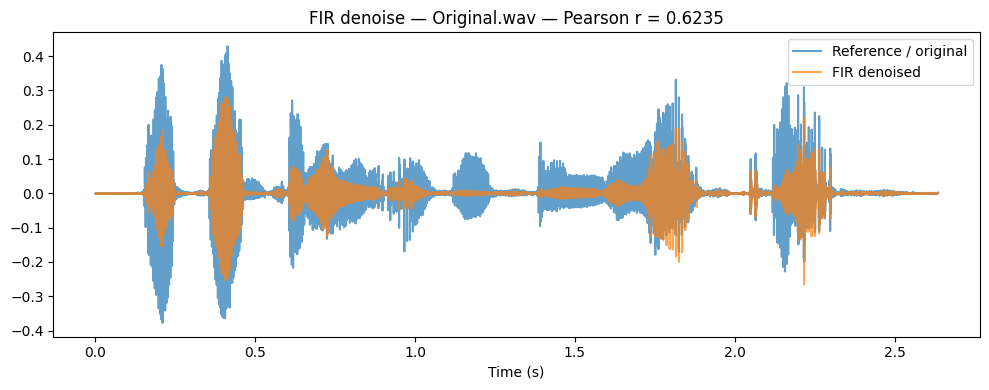

Saved FIR denoised file -> output_audio/OEP456/fir_out/Original_fir_denoised.wav
No clean file found for sp30_airport_sn5.wav. Correlation will be with original (noisy) signal.


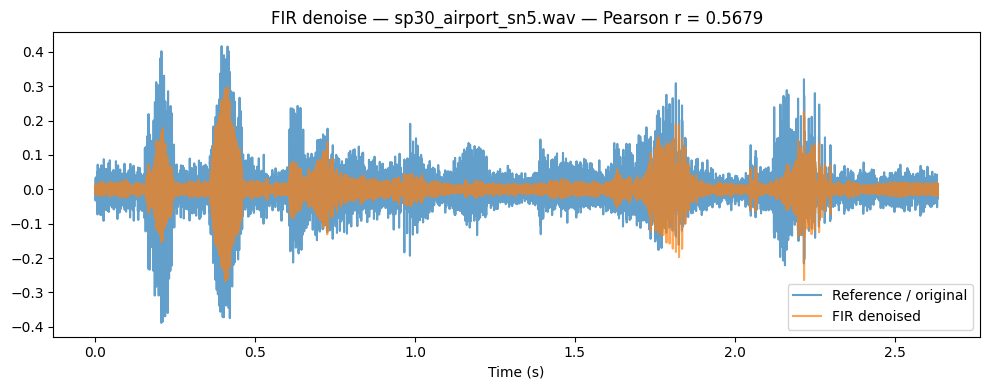

Saved FIR denoised file -> output_audio/OEP456/fir_out/sp30_airport_sn5_fir_denoised.wav
No clean file found for sp30_babble_sn5.wav. Correlation will be with original (noisy) signal.


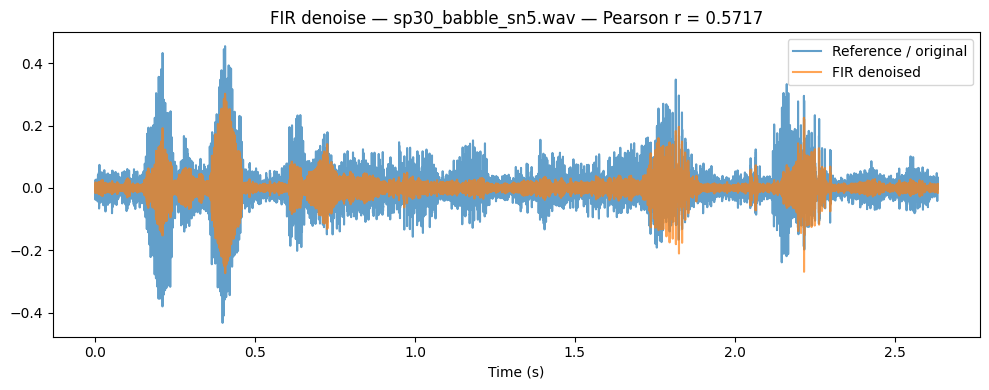

Saved FIR denoised file -> output_audio/OEP456/fir_out/sp30_babble_sn5_fir_denoised.wav
No clean file found for sp30_car_sn5.wav. Correlation will be with original (noisy) signal.


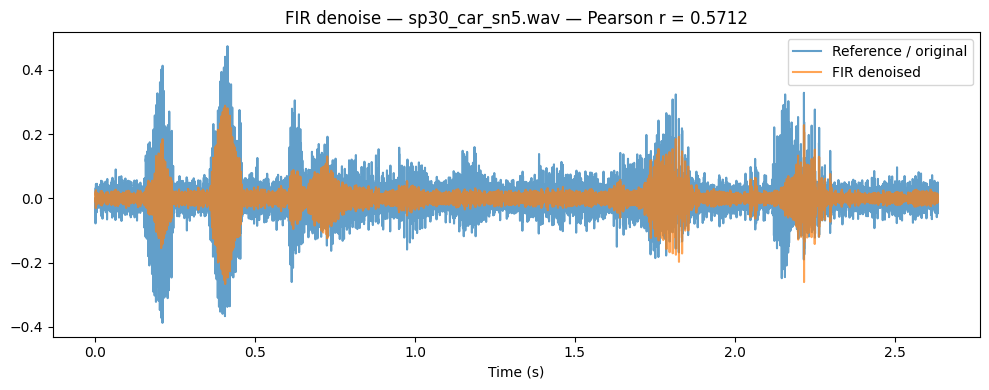

Saved FIR denoised file -> output_audio/OEP456/fir_out/sp30_car_sn5_fir_denoised.wav
No clean file found for sp30_exhibition_sn5.wav. Correlation will be with original (noisy) signal.


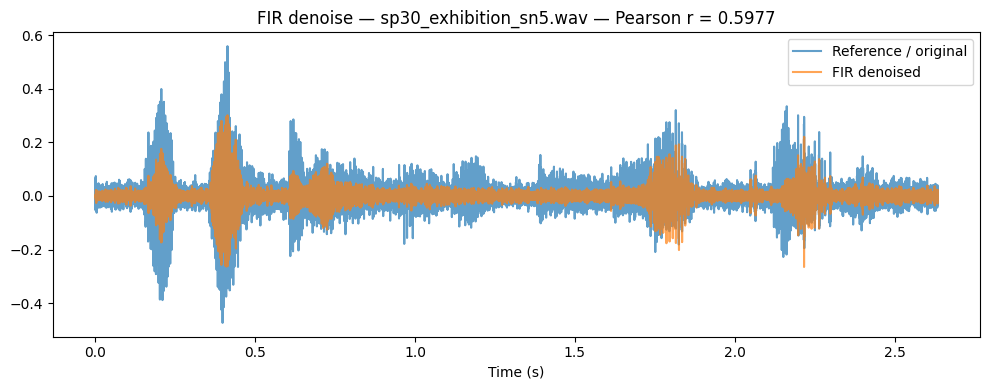

Saved FIR denoised file -> output_audio/OEP456/fir_out/sp30_exhibition_sn5_fir_denoised.wav
No clean file found for sp30_restaurant_sn5.wav. Correlation will be with original (noisy) signal.


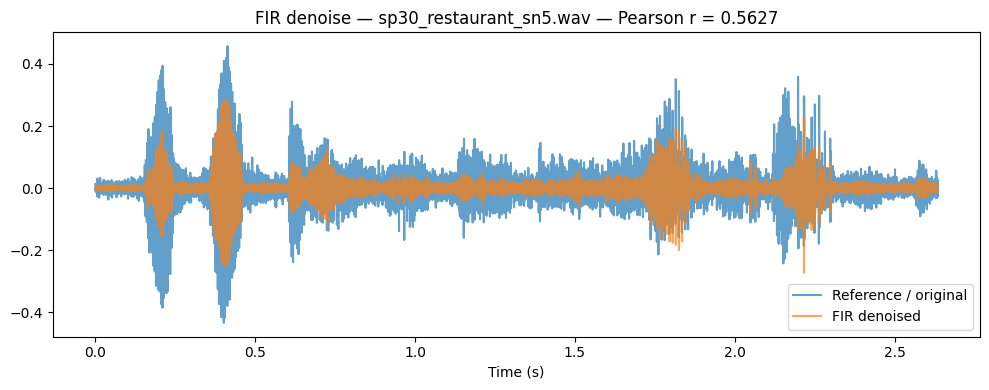

Saved FIR denoised file -> output_audio/OEP456/fir_out/sp30_restaurant_sn5_fir_denoised.wav
No clean file found for sp30_station_sn5.wav. Correlation will be with original (noisy) signal.


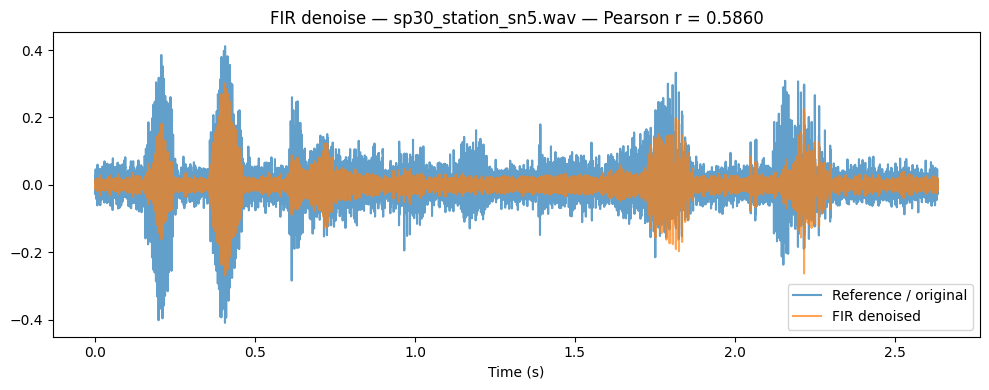

Saved FIR denoised file -> output_audio/OEP456/fir_out/sp30_station_sn5_fir_denoised.wav
No clean file found for sp30_street_sn5.wav. Correlation will be with original (noisy) signal.


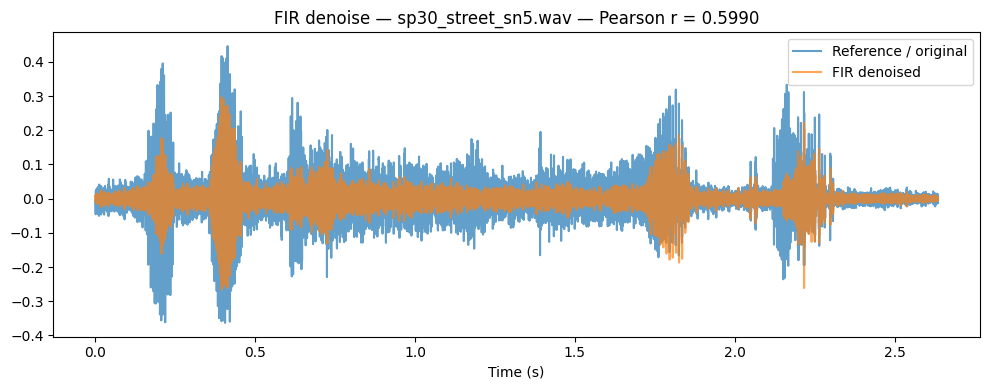

Saved FIR denoised file -> output_audio/OEP456/fir_out/sp30_street_sn5_fir_denoised.wav
No clean file found for sp30_train_sn5.wav. Correlation will be with original (noisy) signal.


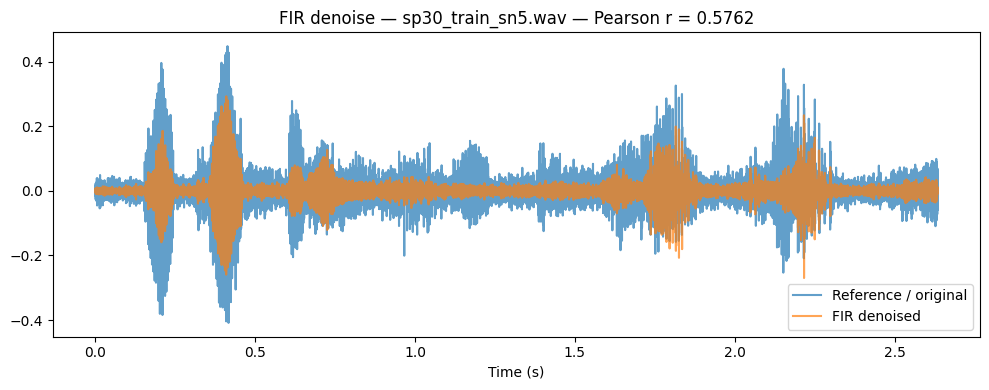

Saved FIR denoised file -> output_audio/OEP456/fir_out/sp30_train_sn5_fir_denoised.wav


In [20]:
import os
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
from scipy.signal import firwin, filtfilt
from scipy.stats import pearsonr

data_folder = "audio/op_end_4_5_6"  
lowcut = 1000.0
highcut = 2000.0
numtaps = 101  # odd number typically

def to_mono(x):
    if x.ndim == 1:
        return x
    return x.mean(axis=1)

def find_clean_candidate(noisy_path):
    d, base = os.path.split(noisy_path)
    name = os.path.splitext(base)[0]
    candidates = [
        os.path.join(d, "clean", base),
        os.path.join(d, name + "_clean.wav"),
        os.path.join(d, "clean_" + base),
        os.path.join(d, "clean", name + ".wav"),
    ]
    for c in candidates:
        if os.path.exists(c):
            return c
    return None

files = sorted([f for f in os.listdir(data_folder) if f.lower().endswith(".wav")])
if not files:
    raise SystemExit("No .wav files found in folder: " + data_folder)

for fname in files:
    noisy_path = os.path.join(data_folder, fname)
    noisy, sr = sf.read(noisy_path)
    noisy = to_mono(noisy)

    ny = 0.5 * sr
    if highcut >= ny:
        print(f"Warning: highcut ({highcut}) >= Nyquist ({ny}). Truncating to Nyquist-1.")
    f1 = max(0.0, lowcut/ny)
    f2 = min(0.999, highcut/ny)

    taps = firwin(numtaps, [f1, f2], pass_zero=False)
    # zero-phase filtering
    denoised = filtfilt(taps, [1.0], noisy)

    clean_candidate = find_clean_candidate(noisy_path)
    if clean_candidate:
        clean, sr2 = sf.read(clean_candidate)
        clean = to_mono(clean)
        if sr2 != sr:
            print(f"Warning: sample rate mismatch for {fname} and clean file; resampling not done.")
    else:
        clean = noisy
        print(f"No clean file found for {fname}. Correlation will be with original (noisy) signal.")

    L = min(len(denoised), len(clean))
    denoised_trim = denoised[:L]
    clean_trim = clean[:L]
    if denoised_trim.std() == 0 or clean_trim.std() == 0:
        corr = 0.0
    else:
        corr, _ = pearsonr(denoised_trim, clean_trim)

    t = np.arange(L) / sr
    plt.figure(figsize=(10, 4))
    plt.plot(t, clean_trim, label='Reference / original', alpha=0.7)
    plt.plot(t, denoised_trim, label='FIR denoised', alpha=0.7)
    plt.title(f"FIR denoise — {fname} — Pearson r = {corr:.4f}")
    plt.xlabel("Time (s)")
    plt.legend()
    plt.tight_layout()
    plt.show()


    # --- Save FIR denoised audio to an existing folder ---
    out_dir = "output_audio/OEP456/fir_out"

    # ensure folder exists (we do NOT create it)
    if not os.path.isdir(out_dir):
        raise FileNotFoundError(f"Output folder does not exist: {out_dir}")

    name_only = os.path.splitext(fname)[0]
    out_path = os.path.join(out_dir, f"{name_only}_fir_denoised.wav")

    # avoid clipping: scale to ±0.99 if necessary
    max_val = np.max(np.abs(denoised))
    if max_val > 0.99:
        denoised_to_write = denoised / max_val * 0.99
    else:
        denoised_to_write = denoised

    # write as 16-bit PCM
    sf.write(out_path, denoised_to_write, sr, subtype="PCM_16")

    print(f"Saved FIR denoised file -> {out_path}")